In [43]:
%matplotlib inline
import random
import torch
import matplotlib.pyplot as plt

(**我们使用线性模型参数$\mathbf{w} = [2, -3.4]^\top$、$b = 4.2$
和噪声项$\epsilon$生成数据集及其标签：

$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon.$$
**)

$\epsilon$可以视为模型预测和标签时的潜在观测误差。
在这里我们认为标准假设成立，即$\epsilon$服从均值为0的正态分布。
为了简化问题，我们将标准差设为0.01。
下面的代码生成合成数据集。


### 生成数据集

In [38]:
def synthetic_data(w,b,num_example):
    X = torch.normal(0,1,(num_example, len(w)))   #随机化X
    y = torch.matmul(X,w)+ b
    y+= torch.normal(0,0.01,y.shape)
    return  X, y.reshape((-1,1))

In [50]:
true_w = torch.tensor([2,-3.4])
true_b = 4.2
features,labels = synthetic_data(true_w,true_b,1000)

In [51]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([-1.5954,  0.6385]) 
label: tensor([-1.1720])


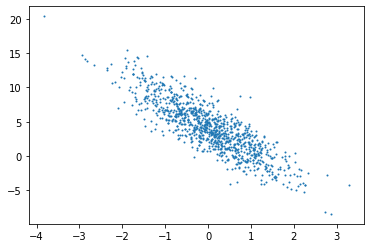

In [52]:
plt.scatter(features[:,1].detach().numpy(), labels.detach().numpy(),1)

### 读取数据集
定义一个data_iter函数，该函数作用：接收批量大小，特征矩阵和标签向量作为输入和输出，生成batch_size的小批量。每个小批量包含一组特征和标签。     
但这种方法的效率非常低，因此在加在数据的时候基本会加载到内存中，使用深度学习框架中的内置迭代器。


In [83]:
# 使用yield 生成数据集的迭代
def data_iter(features,labels,batch_size):
    num_examples = len(features)
    indices = list(range(num_examples))    #生成1000样本的索引-进行打乱
    random.shuffle(indices)                #直接修改了indices的排列
    for i in range(0,num_examples,12):
        batch_indices = torch.tensor(indices[i:min(i+12,num_examples)]) 
        yield features[batch_indices], labels[batch_indices]


In [82]:
batch_size=12
for X,y in data_iter(features,labels,batch_size):
    print(X,'\n',y)
    break

tensor([[ 0.9777,  0.9681],
        [ 2.7838, -1.4217],
        [-0.5695, -1.0710],
        [-0.6804,  0.2141],
        [-0.1475,  1.0837],
        [ 0.5921,  0.6840],
        [ 0.4961,  0.2639],
        [-1.0918,  2.0443],
        [ 0.6851,  0.3408],
        [-0.2288, -0.6387],
        [-0.4020, -0.0272],
        [-0.6529, -1.0539]]) 
 tensor([[ 2.8550],
        [14.5882],
        [ 6.6945],
        [ 2.1023],
        [ 0.2182],
        [ 3.0699],
        [ 4.2963],
        [-4.9527],
        [ 4.4122],
        [ 5.9077],
        [ 3.4999],
        [ 6.4842]])


### 初始化参数模型
生成小批量的数据集以后，需要一些参数，
- 初始化权重本文采用mean=0， std=0.01的正态分布的随机数，调用torch.normal()
- 偏置为0，调用torch.zeros()      
但这种方式容易出现错误，因此会引入自动微分来计算梯度

In [85]:
w =  torch.normal(0,0.01,(2,1),requires_grad=True)
b = torch.zeros(1,requires_grad=True) #可以进行广播，所以shape只设置1

### 定义模型
将数据集的输入和输出以及参数联系起来，就需要定义一个模型来计算。在线性模型中，输入为[X,w,b]->y

In [90]:
def linreg(X,w,b):
    return torch.matmul(X,w)+b

### 定义损失函数
损失函数就是上述使用的极大似然方法而推导出来的损失函数方法

In [107]:
def squared_loss(y_hat,y):
    return (y_hat-y.reshape(y_hat.shape))**2/2

### 定义优化算法
对损失函数进行优化到0，在负梯度的方向进行减小，随机梯度下降更新SGD，Adam等优化算法，需要有学习速率，参数集合和批量大小的输入。每步更新的大小由lr决定，每次小批量更新需要对batch_size进行平均处理

In [93]:
def sgd(params,lr,batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr*param.grad/batch_size
            param.grad.zero_()

### 训练
定义完所有的组块，需要进行训练了。在每次迭代中，
1. 读取小批量数据，并通过模型获得预测。
2. 损失函数，并进行反向传播，存储每个参数的梯度
3. 调用优化算法sgd来更新模型参数
-------
-  初始化参数
-  定义num_iter，更新梯度，直到完成（损失达到想到的标准）

 * 计算梯度$\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
 * 更新参数$(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$
 
 在每个跌代周期中，使用data_iter遍历整个数据集，超参数为lr和迭代次数num_epochs,超参数需要实验的结果进行调整简称调参

In [122]:
lr=0.03
num_epochs=3
net = linreg
loss = squared_loss

In [123]:
for epoch in range(num_epochs):
    for X,y in data_iter(features,labels,batch_size):
        pre = net(X,w,b)
#         print(pre)
#         print(y)
        l = loss(pre,y)# 小批量的loss 大小[batch_size,1],不是标量，计算{w,b}的梯度
        l.sum().backward() # 必须是标量对向量的反向传播
        sgd([w,b],lr,batch_size)    #进行参数更新
#         print([w,b])
    with torch.no_grad():
        train_l = loss(net(features,w,b),labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')
    print(w,b)
        

epoch 1, loss 0.000048
tensor([[ 1.9995],
        [-3.4001]], requires_grad=True) tensor([4.1999], requires_grad=True)
epoch 2, loss 0.000048
tensor([[ 1.9995],
        [-3.4001]], requires_grad=True) tensor([4.1998], requires_grad=True)
epoch 3, loss 0.000048
tensor([[ 1.9996],
        [-3.4003]], requires_grad=True) tensor([4.2002], requires_grad=True)


In [124]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([0.0004, 0.0003], grad_fn=<SubBackward0>)
b的估计误差: tensor([-0.0002], grad_fn=<RsubBackward1>)


注意，我们不应该想当然地认为我们能够完美地求解参数。
在机器学习中，我们通常不太关心恢复真正的参数，而更关心如何高度准确预测参数。
幸运的是，即使是在复杂的优化问题上，随机梯度下降通常也能找到非常好的解。
其中一个原因是，在深度网络中存在许多参数组合能够实现高度精确的预测。

## 小结

* 我们学习了深度网络是如何实现和优化的。在这一过程中只使用张量和自动微分，不需要定义层或复杂的优化器。
* 这一节只触及到了表面知识。在下面的部分中，我们将基于刚刚介绍的概念描述其他模型，并学习如何更简洁地实现其他模型。

## 练习

1. 如果我们将权重初始化为零，会发生什么。算法仍然有效吗？
1. 假设试图为电压和电流的关系建立一个模型。自动微分可以用来学习模型的参数吗?
1. 能基于[普朗克定律](https://en.wikipedia.org/wiki/Planck%27s_law)使用光谱能量密度来确定物体的温度吗？
1. 计算二阶导数时可能会遇到什么问题？这些问题可以如何解决？
1. 为什么在`squared_loss`函数中需要使用`reshape`函数？
1. 尝试使用不同的学习率，观察损失函数值下降的快慢。
1. 如果样本个数不能被批量大小整除，`data_iter`函数的行为会有什么变化？
